# Popularity of Netflix Movies

Group Number: 98 / Group Members: Nusaibah Hossain, Shaloo Menon, Yingming Sha, Tovia Wolfe

### Introduction
Netflix is a streaming service that provides a wide variety of TV shows, movies, anime, documentaries and more on thousands of internet-connected devices. All movies are rated (scores, votes, popularity) using IMDb (Internet Movie Database)  and TMDB (The Movie Database). IMDb registered users can cast a vote (from 1 to 10) on every released title in the database. Individual votes are then aggregated and summarized as a single IMDb rating, visible on the title's main page. TMDB is a similar database, but instead of registered users, they receive requests to rate and rank, and approve them accordingly. Both IMDb and TMDB have ratings (scores) that is then summarized as "popularity" and "votes" for the movies and shows.
  
The question we are trying to answer is: Can we predict TMDB popularity using IMDb Score, TMDB Score, and IMDb Votes?

For the answer to the question, we are using the dataset that contains a list of movies available on Netflix streaming and was acquired in July 2022 containing data available in the United States. The dataset includes the variables (id (the title ID on JustWatch), title (the name of the title), show_type (TV show or movie), description (a short description), release_year (year it was released), age_certification (the age certification), runtime (the length of the episode (SHOW) or movie), genres (list of genres), production_countries (countries producin the title), seasons (Number of seasons if it's a SHOW), imdb_id (the title ID on IMDb), imdb_score (score on IMDb), imdb_votes (votes on IMDb), tmdb_popularity (popularity on TMDb), tmdb_score (score on TMDB).

#### Columns

| id | Key                | Description|
|----|--------------------|--------------------------------------------|
|1   |id                  | The title ID on JustWatch                  |
|2   |title               | The name of the title                      |
|3   |show_type           | TV show or movie                           |
|4   |description         | A brief description                        |
|5   |release_year        | The release year                           |
|6   |age_certification   | The age certification                      |
|7   |runtime             | The length of the episode (SHOW) or movie  |
|8   |genres              | A list of genres                           |
|9   |production_countries| A list of countries that produced the title|
|10  |seasons             | Number of seasons if it's a SHOW           |
|11  |imdb_id             | The title ID on IMDB                       |
|12  |imdb_score          | Score on IMDB                              |
|13  |imdb_votes          | Votes on IMDB                              |
|14  |tmdb_popularity     | Popularity on TMDB                         |
|15  |tmdb_score          | Score on TMDB                              |

### The Method We Will Be Using
We will be conducting our analysis using knn-regression. In doing so, we will try to see whether we can accurately predict TMDb popularity based on IMDb scores, IMDb votes and TMDb score using the knn-regression algorithm. We will first test out 200 k-values to determine which k-value results in the smallest root means square error and then use that k-value to carry out our regression. 

Our expected outcome is to find if a higher overall rating (IMDb scores, IMDb votes, TMDb score) results in higher popularity of the movie and that generally, points with similar IMDb scores, IMDb votes and TMDb score will have similar TMDb popularity. Based on the findings, we can predict which factors will affect the popularity of a movie more distinctly, if at all. The impact this would have is it would help Netflix know which movies will be the best to put onto their website. They would be able to know which movies will be most popular on their site based on the ratings, maximizing the success of their website.

We will be describing our methods and steps further as we go. 


In [127]:
#First we load the libraries for our regression
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### Exploratory Data Analysis
First, we load data from the original source on the web. Then, we filter out only movies from the data and select the only numerical predictor variables since we want to predict numerical values.

In [128]:
#loads data from the original source on the web 
titles_data <- read_csv("https://github.com/sm020402/dsci-100-2022w1-group-98/raw/main/project_proposal/data/titles.csv")

#filter out only movies from the data and select only the columns with number values
titles_movie_data <- titles_data %>%
    filter(type == "MOVIE") %>%
    select(runtime, release_year, tmdb_popularity,imdb_score, imdb_votes, tmdb_popularity, tmdb_score)
cat("Table 1: Only Movie Data and Numerical Columns")
titles_movie_data

Rows: 5850 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): id, title, type, description, age_certification, genres, production...
dbl (7): release_year, runtime, seasons, imdb_score, imdb_votes, tmdb_popula...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Table 1: Only Movie Data and Numerical Columns

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
114,1976,40.965,8.2,808582,8.179
109,1972,10.010,7.7,107673,7.300
91,1975,15.461,8.2,534486,7.811
⋮,⋮,⋮,⋮,⋮,⋮
134,2021,NA,7.7,348,NA
90,2021,26.005,3.8,68,6.3
37,2021,1.296,NA,NA,10.0


Then, we check how many missing values are in our dataset and remove all the invalid values.

In [129]:
#We do this step to see how many much of our data is unusable values

titles_missing_values <- sapply(titles_movie_data, function(x) sum(is.na(x))) #count missing values for every column in dataset
titles_missing_values   

runtime    release_year tmdb_popularity      imdb_score      imdb_votes 
              0               0              62             315             331 
     tmdb_score 
            195

In [130]:
# We then proceeded to remove the data associated with those values
titles_movie <- na.omit(titles_movie_data) 
cat("Table 2: Movie Data without Invalid Data")
titles_movie

Table 2: Movie Data without Invalid Data

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
114,1976,40.965,8.2,808582,8.179
109,1972,10.010,7.7,107673,7.300
91,1975,15.461,8.2,534486,7.811
⋮,⋮,⋮,⋮,⋮,⋮
25,2021,53.762,5.6,38,6.3
93,2021,2.545,5.0,327,5.3
90,2021,26.005,3.8,68,6.3


#### Tidying data for preprocessing
Up until now, we loaded, wrangled, cleaned, filtered and made our data tidy to specify the predictors and response variable (TMDB Popularity). 

Then, we split the data into training and testing sets to preprocess our data for our analysis. We also try to find the range and means of our data to get a better sense of the relative values of each category and the differences between them. 

In [131]:
#We set the seed once at the beginning to ensure that our analysis is reproducible
set.seed(1)

#Here we split our data into training and testing data
titles_split <- initial_split(titles_movie, prop = 0.75 , strata = tmdb_popularity)
titles_training <- training(titles_split)
titles_testing <- testing(titles_split)

In [132]:
cat("Table 3: Training Data")
titles_training

Table 3: Training Data

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
97,1972,1.268,6.2,418,6.1
133,1979,1.370,7.2,1727,6.0
129,1969,1.265,8.1,1958,8.5
⋮,⋮,⋮,⋮,⋮,⋮
64,2021,34.522,4.7,53,7.6
25,2021,53.762,5.6,38,6.3
90,2021,26.005,3.8,68,6.3


In [133]:
cat("Table 4: Testing Data")
titles_testing

Table 4: Testing Data

runtime,release_year,tmdb_popularity,imdb_score,imdb_votes,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
114,1976,40.965,8.2,808582,8.179
117,1966,13.123,7.3,16446,7.100
115,1954,8.915,7.5,42488,7.200
⋮,⋮,⋮,⋮,⋮,⋮
148,2021,1.978,5.1,1497,5.3
92,2021,1.971,6.8,1007,7.5
101,2021,1.748,5.0,136,6.7


In [134]:
# This step tells us how big of a difference there is in the ranges of our variables.
# That way we know whether we need to scale the data or not.

titles_mean <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(mean, na.rm = TRUE)
cat("Table 5: The Mean For Each Column")
titles_mean

titles_max <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(max, na.rm = TRUE)

titles_min <- titles_training %>%
    select(runtime, imdb_score, imdb_votes, tmdb_popularity, tmdb_score) %>%
    map_df(min, na.rm = TRUE)

titles_range <- titles_max - titles_min
cat("\nTable 6: The Range For Each Column")
titles_range

Table 5: The Mean For Each Column

runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101.6157,6.272379,28741.47,21.31249,6.461674



Table 6: The Range For Each Column

runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223,7.5,2294226,2273.444,9


The result above with the ranges and means tell us that the different categories span vastly different scales and that the data will need to be scaled and centered.

#### Visualizations
For our visualizations, we decided to plot TMDB Popularity (which is our dependant variable) against each of the variables we are using to predict it. This allows us to observe the relationship between each of the variables and the popularity individually so that we can make predictions about which of the variables is doing the best at predicting popularity, and/or if they are predicting popularity at all. It also allows us to see if the relationships are linear or non-linear which gives us clues about how we should plan to do our regression. We chose to plot the variables we did because out of our original data frame these were the variables that had numerical values, and could be easily plotted. We also chose these variables because scores and votes are often tied to popularity.

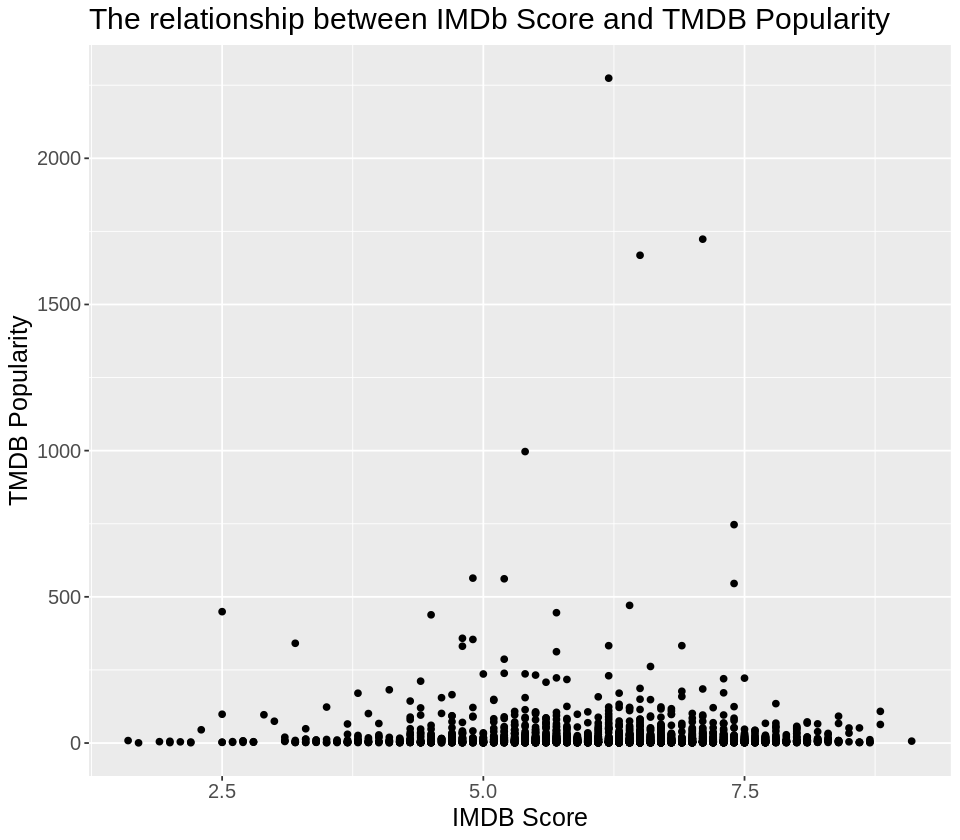

In [135]:
#Here we have visualized what our data looks like so far so that we can devise a plan for what further steps we need to take for our regression.

options(repr.plot.width = 8, repr.plot.height = 7) 
iscore_plot <- titles_training %>%
    ggplot(aes(x = imdb_score, y = tmdb_popularity)) +
    geom_point() +
    labs(x = "IMDB Score", y = "TMDB Popularity") +
    ggtitle("The relationship between IMDb Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

iscore_plot

##### IMDb Score and TMDB Popularity graph
Based on the iscore_plot, the scatterplot shows there is no linear relationship between the variables IMDb Score and TMDB Popularity. Majority of the points are close to the x-axis.

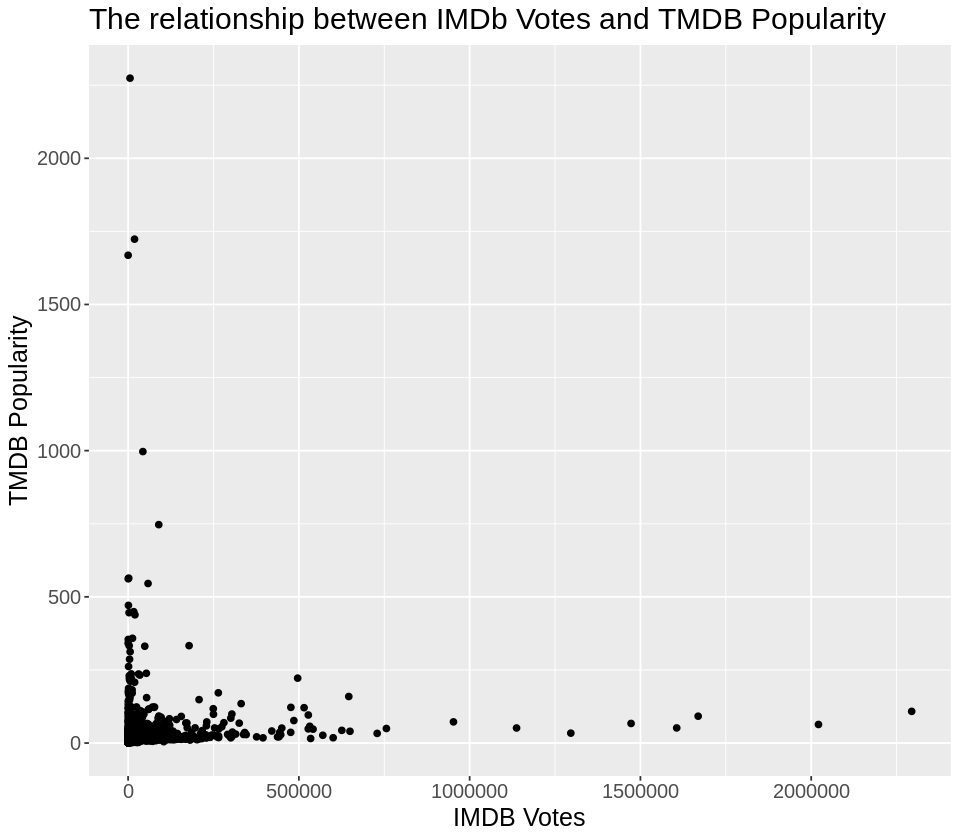

In [136]:
options(repr.plot.width = 8, repr.plot.height = 7) 
ivotes_plot <- titles_training %>%
    ggplot(aes(x = imdb_votes, y = tmdb_popularity)) +
    geom_point() +
    labs(x ="IMDB Votes", y ="TMDB Popularity") +
    ggtitle("The relationship between IMDb Votes and TMDB Popularity")+
    theme(text = element_text(size = 15))

ivotes_plot

##### IMDb Votes and TMDB Popularity graph
Based on the ivote_plot, the scatterplot shows there is no linear relationship between the variables IMDb Votes and TMDB Popularity. Majority of the points are close to the origin.


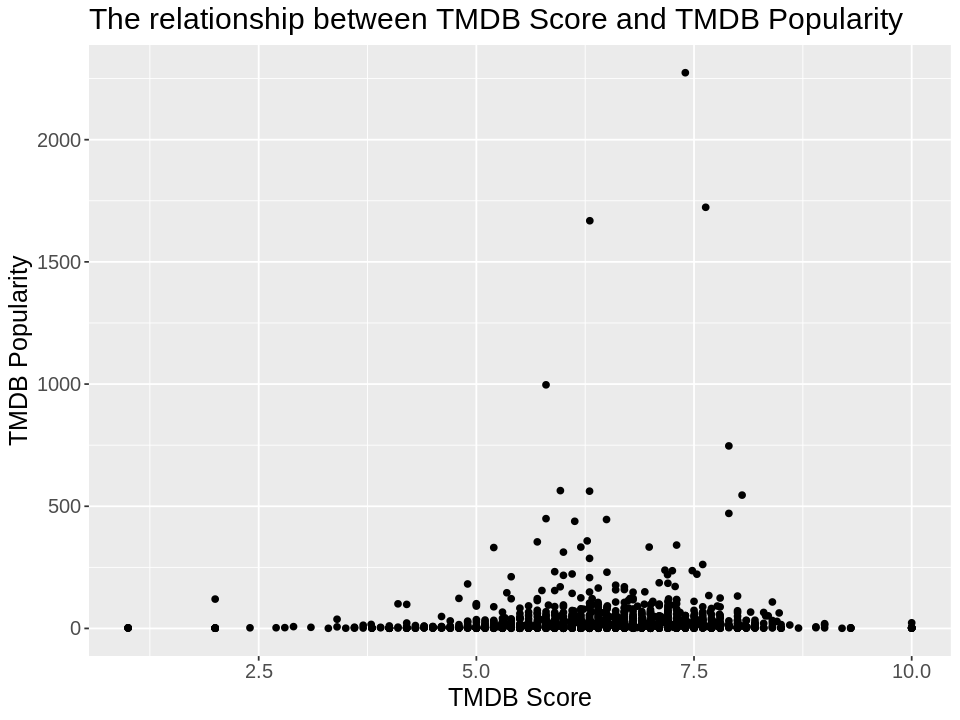

In [137]:
options(repr.plot.width = 8, repr.plot.height = 6) 
tscore_plot <- titles_training %>%
    ggplot(aes(x =  tmdb_score, y =tmdb_popularity)) +
    geom_point() +
    labs(x = "TMDB Score", y = "TMDB Popularity") +
    ggtitle("The relationship between TMDB Score and TMDB Popularity")+
    theme(text = element_text(size = 15))

tscore_plot

##### TMDB Score and TMDB Popularity graph
Based on the tscore_plot, the scatterplot shows there is no linear relationship between the variables TMDB score and TMDB Popularity. Majority of the points are close to the x-axis. 

### Choosing the regression model to use
Using the above graphs, it seems there is not a visible linear relationship between the predictors and the dependant variable. This is why we chose to do a knn regression, instead of a linear regression.

In [138]:
#Our data is then split randomly into equally sized groups
set.seed(1)
titles_vfold <- vfold_cv(titles_training, v = 5, strata = tmdb_popularity)

#Here we scaled our variables
titles_recipe <- recipe(tmdb_popularity ~ imdb_score + imdb_votes + tmdb_score, data = titles_training) %>%
      step_scale(all_predictors()) %>%
      step_center(all_predictors())

#We then created a Knn Regression model which approximates the association between the variables.
titles_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression")
titles_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [139]:
#The workflow predicts the outcome of a new observation by comparing it to a given number ‘k’ 
titles_workflow <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_spec)
titles_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Processing the dataset
We completed the preprocessing by scaling and centering our training data set and then processed the data by creating a workflow.

In [144]:
#We found the accuracy of our predictions that use all three of our variables
gridvals <- tibble(neighbors = seq(from = 1, to = 200))
titles_results <- titles_workflow %>%
    tune_grid(resamples = titles_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric =="rmse")
cat("Table 7: Choosing the Best K-values Table")
titles_results

Table 7: Choosing the Best K-values Table

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,96.90140,5,13.61014,Preprocessor1_Model001
2,rmse,standard,87.17589,5,11.88690,Preprocessor1_Model002
3,rmse,standard,84.49398,5,12.18315,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
198,rmse,standard,74.84404,5,16.30222,Preprocessor1_Model198
199,rmse,standard,74.84406,5,16.30661,Preprocessor1_Model199
200,rmse,standard,74.84651,5,16.30570,Preprocessor1_Model200


In [145]:
#This step finds the value of K that minimizes our rmse
titles_min <- titles_results %>%
   filter(mean == min(mean))
cat("Table 8: K-value with the Lowest RMSE")
titles_min

Table 8: K-value with the Lowest RMSE

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
93,rmse,standard,74.74419,5,16.32727,Preprocessor1_Model093


In [146]:
#We then found our averaged RMSE of all of our values which shows how far our datapoints lie from our line of best fit.
k_min <- titles_min %>%
    pull(neighbors)
titles_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("regression") 
titles_best_fit <- workflow() %>%
    add_recipe(titles_recipe) %>%
    add_model(titles_best_spec) %>%
    fit(data = titles_training)
titles_summary <- titles_best_fit %>%
    predict(titles_testing) %>%
    bind_cols(titles_testing) %>%
    metrics(truth = tmdb_popularity, estimate = .pred) %>%
    filter(.metric == 'rmse')
cat("Table 9: Summary")
titles_summary

Table 9: Summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,78.07899


##### K-value and RMSE 
We used cross-validation and filtered to get the minimum mean to find the k-value that yields the lowest rmse, and then found the rmse for that k value. We found the accuracy by creating a knn regression model, a workflow for the model by fitting it to the training data set, and then finally predicted the dependant variable using the testing data set. 

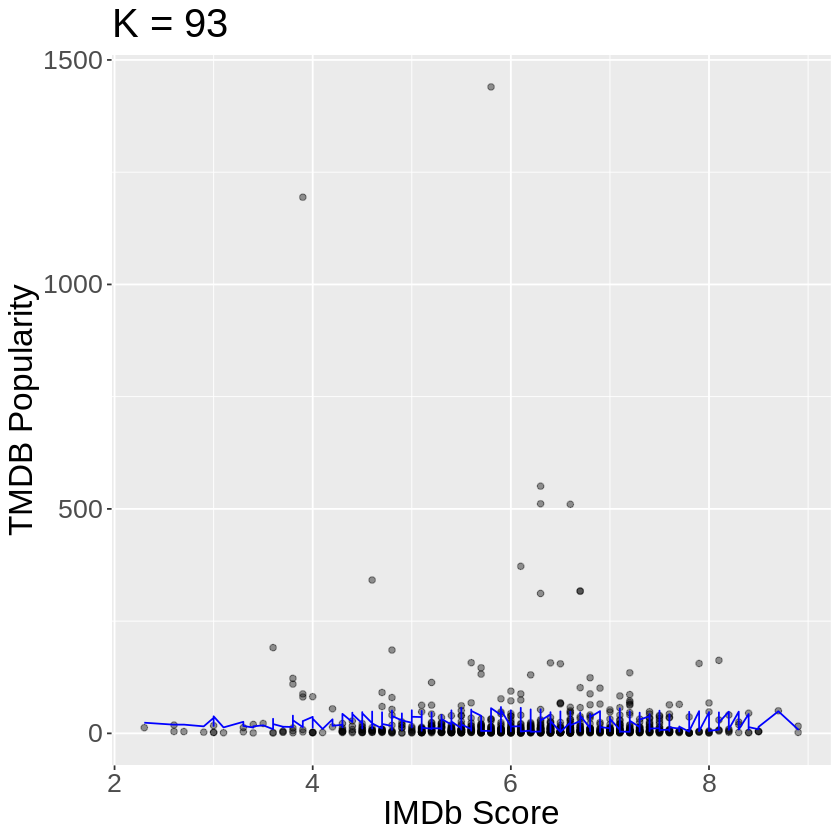

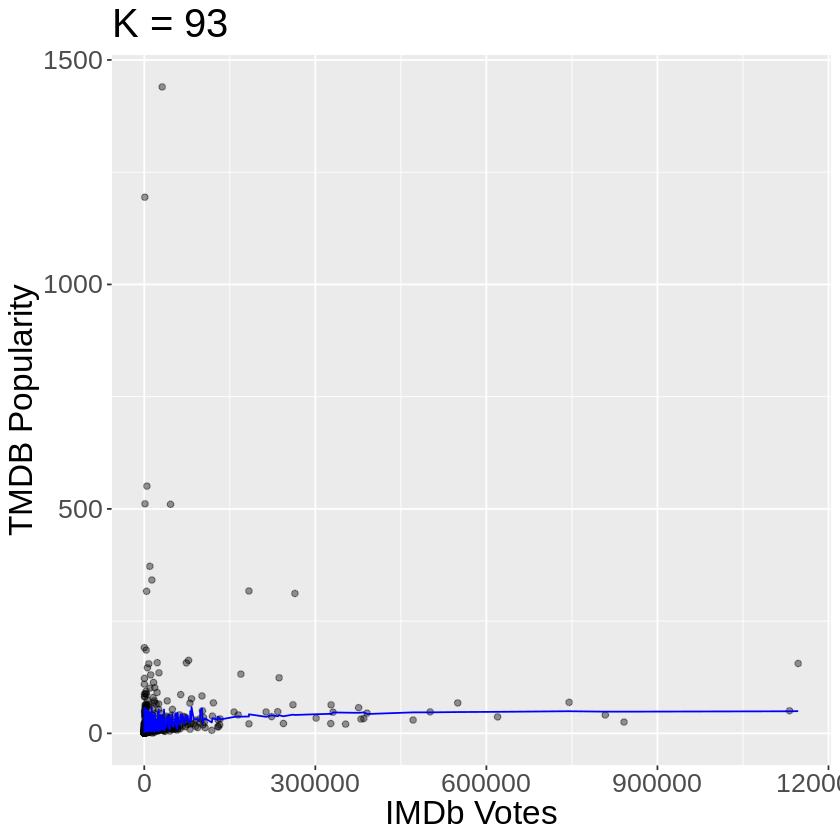

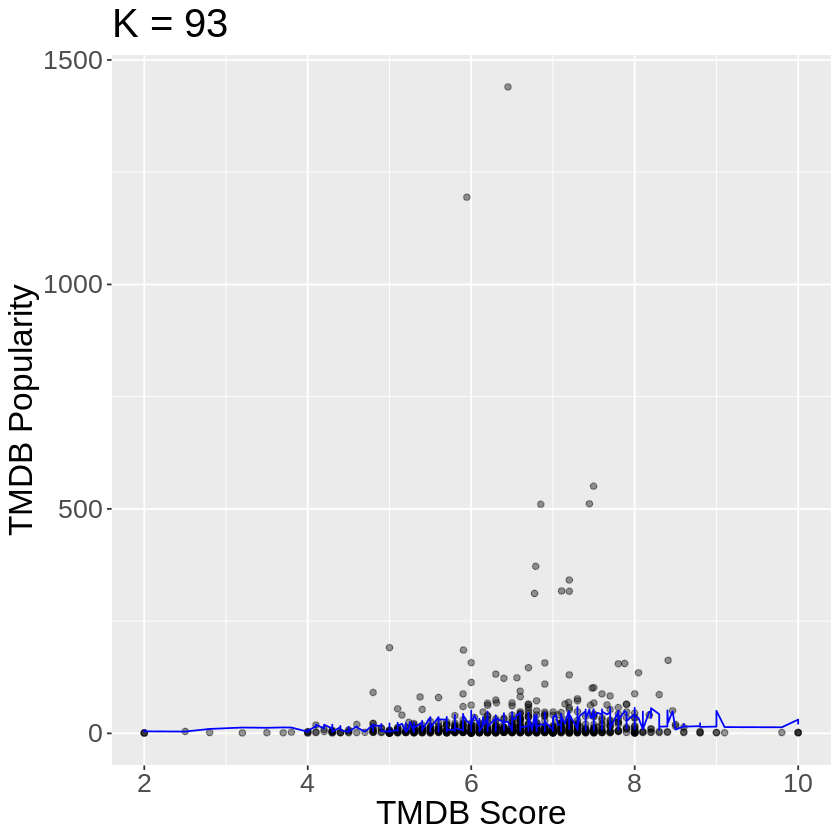

In [147]:
# final visualization

options(repr.plot.width = 7, repr.plot.height = 7)

titles_preds <- titles_best_fit |>
                predict(titles_testing) |>
                bind_cols(titles_testing)

titles_plot_iscore <- ggplot(titles_preds, aes(x = imdb_score, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("IMDb Score") +
            ylab("TMDB Popularity") + 
            geom_line(data = titles_preds, aes(x = imdb_score, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_ivotes <- ggplot(titles_preds, aes(x = imdb_votes, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("IMDb Votes") +
            ylab("TMDB Popularity") + 
            geom_line(data = titles_preds, aes(x = imdb_votes, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_tscore <- ggplot(titles_preds, aes(x = tmdb_score, y = tmdb_popularity)) +
            geom_point(alpha = 0.4) +
            xlab("TMDB Score") +
            ylab("TMDB Popularity") + 
            geom_line(data = titles_preds, aes(x = tmdb_score, y = .pred), color = "blue") +
            ggtitle(paste0("K = ", k_min)) +
            theme(text = element_text(size = 20))

titles_plot_iscore
titles_plot_ivotes
titles_plot_tscore

#### Final Regression Visualizations
Above is our final regression visualizations with a line of best fit for each, which we plotted using the k value we found earlier. The lines of best fit show that there is neither a positive or negative coorelation between TMDB popularity and our predictive variables. This shows there is a lack of correlation in the data and we cannot use our predictive variables to estimate the TMDB popularity like we had hoped. The plot shows the regression line darting between different points, this reflects the idea that there is very little consistency in TMDb popularity between points with similar IMDb Scores, IMDb Votes and TMDB Scores. 

### Results and discussion
We found our root means square error to be 78.08. The root means square error shows how far off the data points are from the line of best fit. Due to our root means square error, the predictions from our model are not as accurate as we had hoped. Therefore the evidence does not support the hypothesis very well. Based on the graphs and the RMSE value, we can conclude that there is no strong correlation between the predictor variables and TMDB Popularity. This means we cannot accurately use IMDb Score, IMDb Votes, and TMDB Score to predict TMDB Popularity. 

Initially, we thought that there should be some correlation between the different predictor variables and TMDB Popularity. Intuitively, it makes sense that a movie that is rated highly on one site would also be rated highly on another site. After the exploratory analysis, the graphs we found seemed to contradict this assumption. Finally, the knn-regression reflected the idea that, despite our hypothesis, IMDb Score, IMDb Votes, and TMDB Score cannot be used to predict TMDB Popularity. 

Our RMSE was so high because there was no correlation in the data. This idea is reinforced by all of our graphs. In each graph, the regression line is erratic and inconsistent indicating that there were no clear patterns between the predictor variables and TMDB Popularity. The RMSE value was so high because the lack of correlation meant an inaccurate prediction by the model and a larger error between each predicted value and actual value. The reason for the lack of correlation is likely because the data itself that we decided to use does not have a significant relationship between the predictors and the TMDB popularity. It is possible that if we had used a different dataset, we would have gotten different results. 

These findings impact the way we view the relationship between different movie rating sites. Since there is no clear correlation between the different listed categories on each site and the ratings on each site, we cannot follow our intuition in saying that a movie that was successful on one site will also be successful on another site. 
This begs the question, what can actually be used to predict the ratings of a movie? In addition, what factors led to such drastic differences in ratings from different sites? 


### References
- Soeiro, V. (2022). Netflix TV Shows and Movies. Kaggle.com. https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies
- Netflix | Founders, History, Shows, & Facts | Britannica. (2022). In Encyclopædia Britannica. https://www.britannica.com/topic/Netflix-Inc
- IMDb | Help. (2022). Imdb.com. https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#
- The Movie Database. (2022). Themoviedb.org. https://www.themoviedb.org/about?language=en-CA
- Group 98 Project Proposal
- Timbers, T. (2022, September 24). Data Science. Datasciencebook.ca. https://datasciencebook.ca/